In [2]:
# general
import os
import glob
import datetime as dt
import json
# data 
import xarray as xr 
from sublimpy import utils, variables, tidy, turbulence
import numpy as np
import pandas as pd
from act import discovery, plotting
# plotting
import matplotlib.pyplot as plt
import plotly.express as px 
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from mpl_toolkits.basemap import Basemap
import cufflinks as cf
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
from PIL import Image
from matplotlib.animation import PillowWriter, FFMpegWriter
# helper tools
from metpy import calc, units
# make plotly work 
init_notebook_mode(connected=True)
cf.go_offline()
# stats
import scipy.stats as stats
import seaborn as sns
import shapely.geometry as shp

In [3]:
# get the coordingates of Grand Junction, CO
gj = shp.Point(-108.5506, 39.0639)
# get the coordinates of Gothic, CO
gothic = shp.Point(-106.9898, 38.9592)
line = shp.LineString([gj, gothic])


In [33]:
ds = xr.open_dataset('/storage/dlhogan/data/processed_data/ERA5_reanalysis_western_NA_2023.nc')
poi = slice('2023-03-04T00:00:00', '2023-03-09T23:00:00')

# subset the data   
ds_subset = ds.sel(time=poi)

# calculate the wind speed and direction
ds_subset['wind_speed'] = np.sqrt(ds_subset.u**2 + ds_subset.v**2)
# create a column with the wind direction
ds_subset['wind_dir'] = np.arctan2(ds_subset['v'], ds_subset['u']) * 180 / np.pi
# convert wind direction to compass direction
ds_subset['wind_dir'] = (270 - ds_subset['wind_dir']) % 360
# calculate dew point from relative humidity and temeprature
ds_subset['dew_point'] = calc.dewpoint_from_relative_humidity(ds_subset.t, ds_subset.r)
# convert temperature to celsius
ds_subset['t'] = units.units('C') * (ds_subset['t']-273.15)

ds_subset_700 = ds_subset.sel(level=500)

/tmp/ipykernel_2937/2440258119.py:14: UserWarning:

Relative humidity >120%, ensure proper units.

/home/dlhogan/miniforge3/envs/sublime_synoptics/lib/python3.11/site-packages/metpy/calc/thermo.py:1396: RuntimeWarning:

invalid value encountered in log



In [34]:
def clippedcolorbar(CS, **kwargs):
    from matplotlib.cm import ScalarMappable
    from numpy import arange, floor, ceil
    fig = CS.get_figure()
    vmin = CS.get_clim()[0]
    vmax = CS.get_clim()[1]
    m = ScalarMappable(cmap=CS.get_cmap())
    m.set_array(CS.get_array())
    m.set_clim(CS.get_clim())
    step = CS.levels[1] - CS.levels[0]
    cliplower = CS.zmin<vmin
    clipupper = CS.zmax>vmax
    noextend = 'extend' in kwargs.keys() and kwargs['extend']=='neither'
    # set the colorbar boundaries
    boundaries = arange((floor(vmin/step)-1+1*(cliplower and noextend))*step, (ceil(vmax/step)+1-1*(clipupper and noextend))*step, step)
    kwargs['boundaries'] = boundaries
    # if the z-values are outside the colorbar range, add extend marker(s)
    # This behavior can be disabled by providing extend='neither' to the function call
    if not('extend' in kwargs.keys()) or kwargs['extend'] in ['min','max']:
        extend_min = cliplower or ( 'extend' in kwargs.keys() and kwargs['extend']=='min' )
        extend_max = clipupper or ( 'extend' in kwargs.keys() and kwargs['extend']=='max' )
        if extend_min and extend_max:
            kwargs['extend'] = 'both'
        elif extend_min:
            kwargs['extend'] = 'min'
        elif extend_max:
            kwargs['extend'] = 'max'
    return fig.colorbar(m, **kwargs)

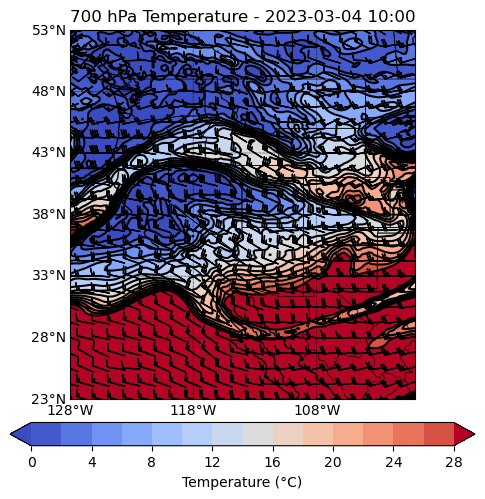

In [35]:
# create Pillow writer object
metadata = dict(title='ERA5 700 hPa Temperature', artist='DLHogan')
writer = PillowWriter(fps=3, metadata=metadata,)

# Create the figure and basemap
fig = plt.figure(figsize=(6, 6))


# with writer.saving(fig, "temperature.gif", 100):
for i,t in enumerate(ds_subset_700['time'][10:11]):
    # clear the figure
    plt.clf()
    m = Basemap(projection='cyl', llcrnrlon=-128, llcrnrlat=23, urcrnrlon=-100, urcrnrlat=53, resolution='l')
    m.drawcoastlines(1)
    m.drawcountries()

    # Draw parallels and meridians
    parallels = np.arange(23, 53 + 0.25, 5)
    m.drawparallels(parallels, labels=[1, 0, 0, 0], linewidth=0.5)
    meridians = np.arange(-128, -100 + 0.25, 10)
    m.drawmeridians(meridians, labels=[0, 0, 0, 1], linewidth=0.5)
    m.drawstates()
    # Contour plot for temperature
    cbarticks=np.arange(0.0,30.0,2)
    cf = plt.contourf(ds_subset_700['longitude'], ds_subset_700['latitude'], (ds_subset_700['t'].sel(time=t).to_numpy() - ds_subset_700['dew_point'].sel(time=t).to_numpy()), cbarticks, cmap='coolwarm', vmin=0, vmax=30, extend='both')
    c = plt.contour(ds_subset_700['longitude'], ds_subset_700['latitude'], (ds_subset_700['t'].sel(time=t).to_numpy() - ds_subset_700['dew_point'].sel(time=t).to_numpy()), cbarticks, colors='k')
    cb = fig.colorbar(cf, orientation='horizontal', pad=0.05, label='Temperature (°C)')

    # add title of the time
    plt.title(f'700 hPa Temperature - {ds_subset_700["time"].sel(time=t).dt.strftime("%Y-%m-%d %H:%M").item()}')
    # Add barbs for wind, showing every 10th barb
    lon, lat = np.meshgrid(ds_subset_700['longitude'], ds_subset_700['latitude'])
    m.barbs(lon[::5, ::5], lat[::5, ::5], ds_subset_700['u'][i, ::5, ::5], ds_subset_700['v'][i, ::5, ::5], length=5, pivot='middle')
        
    
        # writer.grab_frame()
    

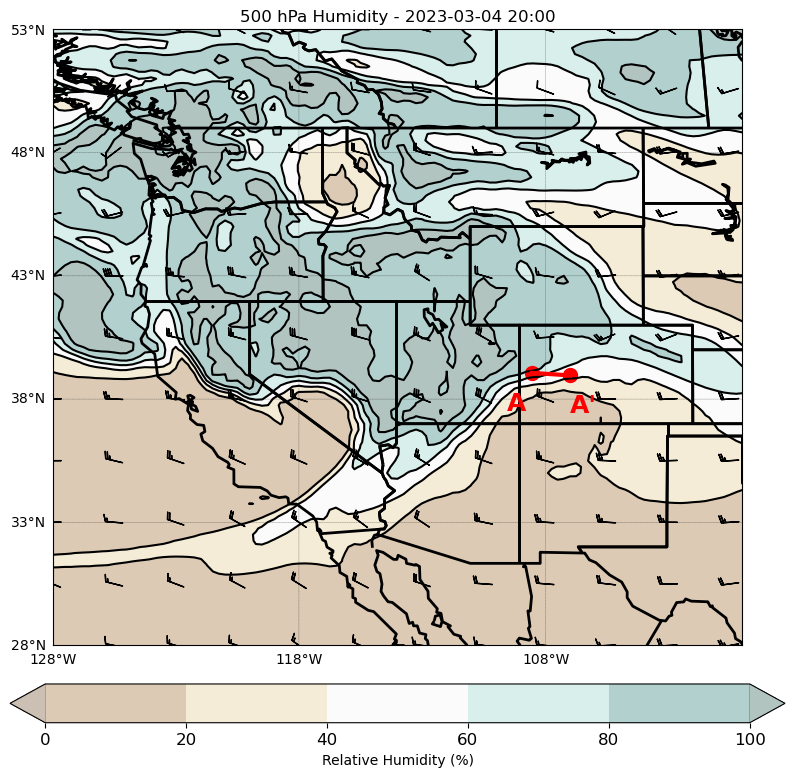

In [50]:
# create Pillow writer object
metadata = dict(title='ERA5 500 hPa Temperature', artist='DLHogan')
writer = PillowWriter(fps=3, metadata=metadata,)

# Create the figure and basemap
fig = plt.figure(figsize=(10, 10))


# with writer.saving(fig, "relative_humidity.gif", 100):
for i,t in enumerate(ds_subset_700['time'][20:21]):
    # clear the figure
    plt.clf()
    m = Basemap(projection='cyl', llcrnrlon=-128, llcrnrlat=28, urcrnrlon=-100, urcrnrlat=53, resolution='l')
    m.drawcoastlines(linewidth=2)
    m.drawcountries(linewidth=2)

    # Draw parallels and meridians
    parallels = np.arange(23, 53 + 0.25, 5)
    m.drawparallels(parallels, labels=[1, 0, 0, 0], linewidth=0.25)
    meridians = np.arange(-128, -100 + 0.25, 10)
    m.drawmeridians(meridians, labels=[0, 0, 0, 1], linewidth=0.25)
    m.drawstates(linewidth=2)
    # Contour plot for temperature
    cbarticks=np.arange(0.0,100.0,10)
    cf = plt.contourf(ds_subset_700['longitude'], ds_subset_700['latitude'], (ds_subset_700['r'].sel(time=t).to_numpy()), cbarticks, cmap='BrBG', levels=np.arange(0,110,20), extend='both', alpha=0.3)
    c = plt.contour(ds_subset_700['longitude'], ds_subset_700['latitude'], (ds_subset_700['r'].sel(time=t).to_numpy()), cbarticks, levels=np.arange(0,110,20), colors='k')
    cb = fig.colorbar(cf, orientation='horizontal', pad=0.05, label='Relative Humidity (%)')
    cb.ax.tick_params(labelsize='large')
    
    # add line for the line and label A to A'
    x, y = line.xy
    m.plot(x, y, color='r', linewidth=3)
    m.scatter(gj.x, gj.y, color='r', s=100)
    m.scatter(gothic.x, gothic.y, color='r', s=100)
    plt.text(gj.x-1, gj.y-1.5, 'A', fontsize=18, color='r', fontweight='bold')
    plt.text(gothic.x, gothic.y-1.5, 'A\'', fontsize=18, color='r', fontweight='bold')

    # add title of the time
    plt.title(f'500 hPa Humidity - {ds_subset_700["time"].sel(time=t).dt.strftime("%Y-%m-%d %H:%M").item()}')
    # Add barbs for wind, showing every 10th barb
    lon, lat = np.meshgrid(ds_subset_700['longitude'], ds_subset_700['latitude'])
    m.barbs(lon[::10, ::10], lat[::10, ::10], ds_subset_700['u'][i, ::10, ::10], ds_subset_700['v'][i, ::10, ::10], length=5, pivot='middle')
    

    # writer.grab_frame()
    

# Next Process:
1) download NARR longterm mean data for u, v, q, temperature, height
2) download NARR data for 2022 and 2023. 
3) Calculate anomaly 